In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabpfnwide.classifier import TabPFNWideClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"

### Generate dataset and add noise features

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

# Widen X with noise
noise = np.random.normal(0, 1, (X.shape[0], 18))
X_new = np.hstack((noise, X))
# Permute columns randomly
permutation = np.random.permutation(X_new.shape[1])
X_new = X_new[:, permutation]

# Keep as numpy arrays for TabPFNWideClassifier
X = X_new.astype(np.float32)
y = y.astype(np.int64)

### Load model

In [3]:
CHECKPOINT_PATH = os.path.join(
    "checkpoints",
    "20251212_003233_final_neat-serenity-5.pt",
)
clf = TabPFNWideClassifier(
        model_path=CHECKPOINT_PATH,
        device="cpu",
        n_estimators=1, # Only works with 1 estimator and no grouping.
        features_per_group=1,
        ignore_pretraining_limits=True,
    )


In [4]:
for i, layer in enumerate(clf.model.transformer_encoder.layers):
        # We need to set the flag on the MultiHeadAttention module
        # In TabPFN, this is usually 'self_attn_between_features' for the feature attention
        if hasattr(layer, "self_attn_between_features"):
            layer.self_attn_between_features.save_att_map = True
            layer.self_attn_between_features.number_of_samples = X.shape[0]
            # Initialize attention_map to None just in case, though the code handles it
            layer.self_attn_between_features.attention_map = None
            print(f"Enabled attention map saving for layer {i}")
        else:
            print(f"Warning: Layer {i} does not have 'self_attn_between_features'")

Enabled attention map saving for layer 0
Enabled attention map saving for layer 1
Enabled attention map saving for layer 2
Enabled attention map saving for layer 3
Enabled attention map saving for layer 4
Enabled attention map saving for layer 5
Enabled attention map saving for layer 6
Enabled attention map saving for layer 7
Enabled attention map saving for layer 8
Enabled attention map saving for layer 9
Enabled attention map saving for layer 10
Enabled attention map saving for layer 11
Enabled attention map saving for layer 12
Enabled attention map saving for layer 13
Enabled attention map saving for layer 14
Enabled attention map saving for layer 15
Enabled attention map saving for layer 16
Enabled attention map saving for layer 17
Enabled attention map saving for layer 18
Enabled attention map saving for layer 19
Enabled attention map saving for layer 20
Enabled attention map saving for layer 21
Enabled attention map saving for layer 22
Enabled attention map saving for layer 23


In [10]:
print("Fitting and predicting...")
clf.fit(X, y)
proba = clf.predict_proba(X)

Fitting and predicting...


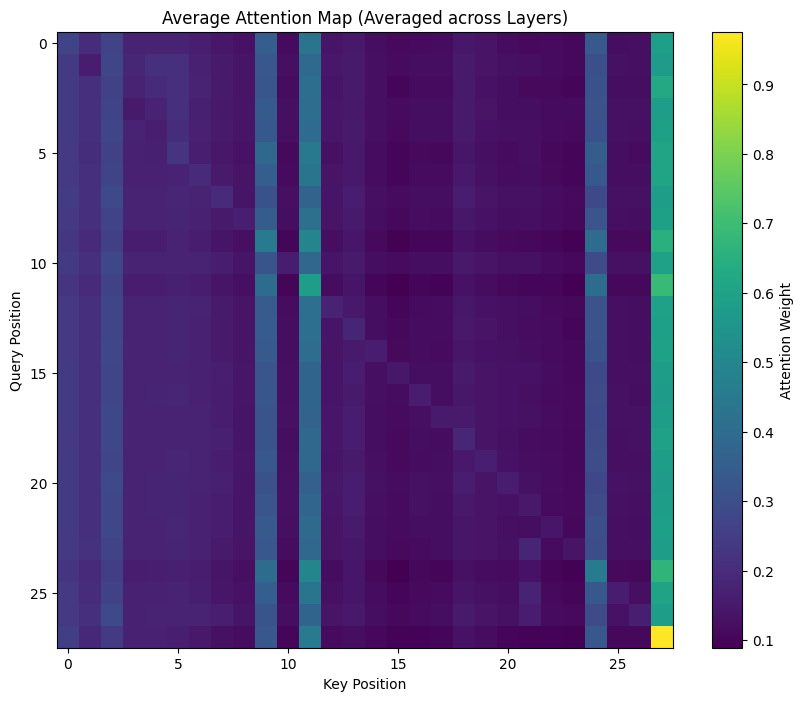

In [11]:
maps = []
for layer in clf.model.transformer_encoder.layers:
    if hasattr(layer, "self_attn_between_features"):
        attn = layer.self_attn_between_features.attention_map
        if attn is not None:
            maps.append(attn.numpy())

# Average across layers for a summary view
avg_map = np.mean(maps, axis=0)

plt.figure(figsize=(10, 8))
plt.imshow(avg_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Attention Weight")
plt.title("Average Attention Map (Averaged across Layers)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

Top 10 feature indices (most important first):
1: feature_27 (score=17.169882)
2: feature_11 (score=11.564050)
3: feature_9 (score=9.621629)
4: feature_24 (score=8.963071)
5: feature_2 (score=7.594346)
6: feature_0 (score=6.690651)
7: feature_1 (score=5.769384)
8: feature_5 (score=5.146619)
9: feature_4 (score=4.909899)
10: feature_3 (score=4.827550)


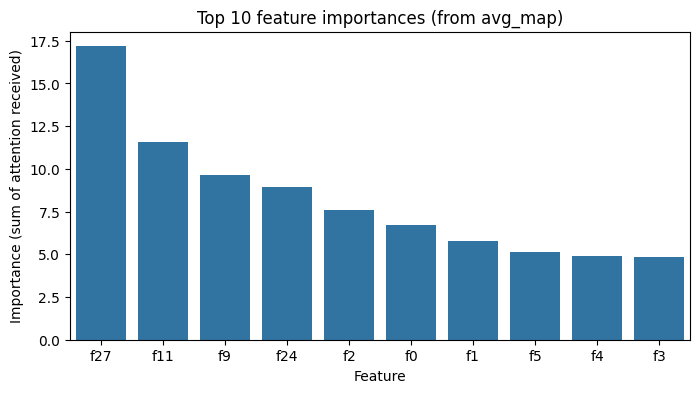

In [13]:
importance = avg_map.sum(axis=0)  # total attention received by each key (feature)
top10 = np.argsort(-importance)[:10]
print("Top 10 feature indices (most important first):")
for rank, idx in enumerate(top10, 1):
    print(f"{rank}: feature_{idx} (score={float(importance[idx]):.6f})")

plt.figure(figsize=(8, 4))
sns.barplot(x=[f"f{idx}" for idx in top10], y=importance[top10])
plt.title("Top 10 feature importances (from avg_map)")
plt.ylabel("Importance (sum of attention received)")
plt.xlabel("Feature")
plt.show()
